In [54]:
import numpy as np
import random
import sys 
from Bio import SeqIO
import re
from ete3 import Tree 
import heapq, operator
import csv
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Functions to calculate Metrics

In [55]:
#====================================================================
# function to read Fasta file
# input - fasta file
# output - array of sequnces names and array of sequences
#====================================================================

def readFasta_for_metrics(fastaFile):
    labels = []
    arraySeqs = []
    with open (fastaFile, 'r') as file:
        for line in file:
            if (line[0] == '>'):
                name = line[1:].replace ('\n', '')
                name = re.sub('@[0-9]*', '', name)
                labels.append(name)
            else:
                arraySeqs.append(line.replace('\n', ''))
    return labels, arraySeqs

In [56]:
#====================================================================
# function to calculate Hamming distance 
# input - two sequences
# output - Hamming distance 
#====================================================================

def hamming_distance_for_metrics(seq1, seq2):
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

In [57]:
#====================================================================
# function to calculate:
# The number of branches 
# Sum of all branch lengths (PD) 
# Sum of all branch lengths divided by the number of clonotypes of the lineage (avPD) 
# input1 - ete3 tree 
# input2 - array of sequnces names 
# input3 - array of sequences
# output - number of branches, PD, avPD
#====================================================================
def metricsPD(tree, labels, arraySeqs):
    num_of_branches = 0
    PD = 0
    avPD = 0.
    
    for parent in tree.traverse("preorder"):
        children = parent.children
        for child in children:
            if child.name != 'naive':
                if child.name == '':
                    remember_parent = parent
                else:
                    if parent.name == '':
                        parent_name = remember_parent.name
                    else:
                        parent_name = parent.name
                    child_name = child.name
                    index_p = labels.index(parent_name)
                    index_c = labels.index(child_name)
                    ham = hamming_distance_for_metrics(arraySeqs[index_p], arraySeqs[index_c])
                    num_of_branches +=1
                    PD += ham
                    #print (parent_name, child_name, ham)
    avPD = PD / num_of_branches
    avPD = round(avPD , 2)
    return num_of_branches, PD, avPD

In [58]:
#====================================================================
# function to choose 3 most abundant sequences
# input - fasta file
# output - array of names for 3 most abundant sequences
#====================================================================

def get_3_most_abundance (file) :
    abundance = {}
    #abundance["total"] = 0
    with open(file) as f:
        for line in f :
            if(line[0] == ">"):
                seq = line.split("\n")[0]
                seq_info = seq.split("@")
                seq_name = seq_info[0][1:]
                if(len(seq_info) == 2) :
                    number_seq = int(seq_info[1])
                    abundance[seq_name] = number_seq
                    #abundance["total"] += number_seq
                else :
                    if seq_name in abundance :
                        abundance[seq_name] += 1
                        #abundance["total"] += 1
                    else :
                        abundance[seq_name] = 1
                        #abundance["total"] += 1
    abud3 = list(zip(*heapq.nlargest(3, abundance.items(), key=operator.itemgetter(1))))[0]
    return abud3

In [59]:
#====================================================================
# function that return:
# The path from nodeName to root 
# input1 - nodeName : name of first node of path,
# input2 - ete3 tree
# output - list of nodes in the path
#====================================================================

def pathToRoot(nodeName, tree):
	D = tree&nodeName
	# Get the path from B to the root
	node = D
	path = []
	while node.up:
		nn = node.name
		if node.name == '' or node.name.isdigit():
			nn = 'none'
		path.append(nn)
		node = node.up
	if path and path[len(path)-1] == 'none':
		path[len(path)-1] = 'naive'
	return path

#====================================================================
# function that return:
# The path from nodeName to nodeFin 
# input - nodeName : name of 1 node of path, nodeFin : name of last node in path (won't print in path), tree
# output - list of nodes in the path
#====================================================================

def pathToNode(nodeName, nodeFin, tree):
	D = tree&nodeName
	node = D
	path = []
	while node.up and node.name != nodeFin:
		nn = node.name
		if node.name == '' or node.name.isdigit():
			nn = 'none'
		path.append(nn)
		node = node.up
	return path


#====================================================================
# function that return:
# The height of a node : the number of edges on the longest path from the node to a leaf. A leaf node will have a height of 0.
# input - name of node that height we want to calculate, tree
# output1 - height
#====================================================================

def height(nodeName, tree):
	leafs = []

	for node in tree.traverse("preorder"):
			if node.is_leaf() == True:
				leafs.append(node.name)

	path_depth = []			
	if nodeName in leafs:
		h = 0
	else:
		h = -1
		for leaf in leafs:
			path = pathToNode(leaf, nodeName, tree)
			len_path = len(path)
			if len_path > h and ('naive' not in path):
				h = len_path
				path_depth = path # for print path and how we received this height
                
	if 'none' in path_depth: #check for unobserved node
		flag = 1
	else:
		flag = 0

	return h

#====================================================================
# function that return:
# The depth of a node : the number of edges from the node to a root. 
# input - name of node that depth we want to calculate, tree
# output1 - depth
#====================================================================

def depth(nodeName, tree):
    path_depth = pathToRoot(nodeName, tree)
    d = len(path_depth) - 1
    
    if 'none' in path_depth: #check for unobserved node
        flag = 1
    else:
        flag = 0
        
    return d

#====================================================================
# function that return:
# The overall depth of tree. 
# input - tree
# output - overall depth
#====================================================================

def TreeSize(tree):

	leafs = []

	for node in tree.traverse("preorder"):
			if node.is_leaf() == True:
				leafs.append(node.name)

	h = -1
	for leaf in leafs:
		path = pathToRoot(leaf, tree)
		len_path = len(path)
		if len_path > h:
			h = len_path

	return h

In [60]:
#===================================================================================================
# function that return:
# Array of depth and height 
# input1 - fasta file
# input2 - tree
# outputs - height array, depth array
#====================================================================================================

def metricsDH(fasta, tree):
    
    array3 = get_3_most_abundance(fasta)
    d_list = []
    h_list = []
    
    for node in array3:
        d_list.append(depth(node, tree))
        h_list.append(height(node, tree))
        
    if len(array3) < 3:
        for i in range (3 - len(array3)):
            d_list.append(None)
            h_list.append(None)
            
    return h_list, d_list

In [61]:
#====================================================================
# function that return:
# all metrics 
# input1 - fasta file
# input2 - Newick file
# output - all metrics
#====================================================================

def allMetrics(input_fasta, input_newick):    
    labels1, arraySeqs1  = readFasta_for_metrics(input_fasta)
    with open (input_newick, 'r') as file:
        for line in file :
            t = Tree(line, format = 1)
    Num1, PD1, avPD1 = metricsPD(t, labels1, arraySeqs1)
    h1, d1 = metricsDH(input_fasta, t)
    size = TreeSize(t)
    return Num1, PD1, avPD1, h1[0], h1[1], h1[2], d1[0], d1[1], d1[2], size

In [62]:
#Check allMetrics for sequences from categorised dataset (categorie 1)
for i in range(1,6):
    file_fasta = 'clonotypes_sequences/categorie1/dataset' + str(i) + '_1_simplifie_sequences.aln.fa'
    file_newick = 'clonotypes_sequences/categorie1output/dataset' + str(i)+'_1_simplifie.abRT.nk'
    print ('Sequance ' + str(i), allMetrics(file_fasta, file_newick))

Sequance 1 (16, 39, 2.44, 2, 1, 1, 1, 2, 2, 4)
Sequance 2 (17, 31, 1.82, 2, 1, 0, 2, 3, 3, 5)
Sequance 3 (17, 53, 3.12, 2, 1, 0, 3, 4, 4, 6)
Sequance 4 (16, 63, 3.94, 2, 1, 0, 3, 4, 4, 6)
Sequance 5 (17, 46, 2.71, 4, 1, 0, 2, 5, 3, 7)


# Analysis of simulated dataset (ClonalTree, GCtree)

In [63]:
dict = {} # {name of sequence : [all metrics]}

#function for metrics of ClonalTree and GCtree sequences from 30_, 40_, 50_, 60_, 70_, 80_, 90_, 100_
def run2arbres(j):    
    for i in range(1,11):
        fastaFile = 'Simulations/' + str(j) + '/' + str(j) + '_'  + str(i) + '.fasta'
        nClonalTree = 'Simulations/' + str(j) + '/' + str(j) + '_' + str(i) +'.clonalTree.nk'
        nGT = 'Simulations/' + str(j) + '/' + str(j) + '_' + str(i)+ '.GT.naive.nk'
        if j < 100:
            dict[nClonalTree[15:-3]] = list(allMetrics(fastaFile, nClonalTree))
            dict[nGT[15:-3]] = list(allMetrics(fastaFile, nGT))
        else:
            dict[nClonalTree[16:-3]] = list(allMetrics(fastaFile, nClonalTree))
            dict[nGT[16:-3]] = list(allMetrics(fastaFile, nGT))
            
#function for metrics of ClonalTree and GCtree sequences from 200_           
def run2arbres200(j):    
    for i in range(1,11):
        if i != 2:
            fastaFile = 'Simulations/' + str(j) + '/' + str(j) + '_'  + str(i) + '.fasta'
            nClonalTree = 'Simulations/' + str(j) + '/' + str(j) + '_' + str(i) +'.clonalTree.nk'
            nGT = 'Simulations/' + str(j) + '/' + str(j) + '_' + str(i)+ '.GT.naive.nk'
            dict[nClonalTree[16:-3]] = list(allMetrics(fastaFile, nClonalTree))
            dict[nGT[16:-3]] = list(allMetrics(fastaFile, nGT))

#function for metrics of ClonalTree and GCtree sequences from 150_  
def run2arbres150(j):    
    for i in [1, 2, 10]:
        fastaFile = 'Simulations/' + str(j) + '/' + str(j) + '_'  + str(i) + '.fasta'
        nClonalTree = 'Simulations/' + str(j) + '/' + str(j) + '_' + str(i) +'.clonalTree.nk'
        nGT = 'Simulations/' + str(j) + '/' + str(j) + '_' + str(i)+ '.GT.naive.nk'
        dict[nClonalTree[16:-3]] = list(allMetrics(fastaFile, nClonalTree))
        dict[nGT[16:-3]] = list(allMetrics(fastaFile, nGT))


numbers = [30, 40, 50, 60, 70, 80, 90, 100] 
for j in numbers:
    run2arbres(j)
    
run2arbres150 (150)   
run2arbres200 (200)

In [64]:
# function for score (Euclidean distance)
def score(a, b):
    mean = (a + b) / 2
    sd = np.sum(np.sqrt(np.square(a - mean) + np.square(b - mean)))
    sd = round (sd, 1)
    ed = np.sqrt(np.sum(np.square(a - b)))
    ed = round(ed, 3)
    met = []
    n = 0
    a_b = a - b 
    metrics = ['Number of branches', 'PD', 'avPD', 'H1', 'H2', 'H3', 'D1', 'D2', 'D3', 'SizeTree']
    
    for i in range(len(metrics)):
        if a_b[i] != 0:
            met.append(metrics[i])       
    return [sd, ed, met]

In [65]:
dict_euclidean = {} # {name of sequence : score}
dict_euclidean_m = {} # {name of sequence : array of absolute value difference for all metrics}
dict_non_zero = {}  #{name of sequence : score, [metrics with difference]}
for key in dict.keys():
    if 'clonalTree' in key:
        a = np.asarray(dict[key])
        ab = key
        ab = re.sub('.[a-z]*[A-Z][a-z]*', '', ab)
    if 'GT.naive' in key:
        b = np.asarray(dict[key])
        a_b = a - b
        if a_b.any() != 0:
            sc = score(a, b)
            dict_euclidean[ab] = sc
            #dict_euclidean[ab] = np.abs(a - b)
        else:
            dict_euclidean[ab] = [0, 0]
        if dict_euclidean[ab] != [0, 0]:
            dict_euclidean_m[ab] = np.absolute(a - b)
            dict_non_zero[ab] = dict_euclidean[ab]

In [66]:
dict_with_scores = {} # {name of sequence : score, groupe 30-100, 150, 200}
d_keys = []
d_score_sd = []
d_score_ed =[]
d_groupe = [] 
    
for key in dict_euclidean.keys():
    if key[0:2] == '10':
        groupe = 100
    elif key[0:2] == '15':
        groupe = 150
    elif key[0:2] == '20':
        groupe = 200
    else :
        groupe = int (key[0:2])
    dict_with_scores[key] = [dict_euclidean[key][0], dict_euclidean[key][1], groupe]
    d_keys.append(key)
    d_score_sd.append(dict_euclidean[key][0])
    d_score_ed.append (dict_euclidean[key][1])
    d_groupe.append(groupe)

In [67]:
# creating a Dataframe object from a list 
df_scores = pd.DataFrame({'Name':d_keys , 'Score_sd': d_score_sd,'Score_ed': d_score_ed,  'Groupe' : d_groupe})

In [68]:
#scores for all repertoires
df_scores

,Name,Score_sd,Score_ed,Groupe
0,30_1,0.00,0.00,30
1,30_2,0.00,0.00,30
2,30_3,0.00,0.00,30
3,30_4,0.00,0.00,30
4,30_5,1.40,1.41,30
...,...,...,...,...
87,200_6,0.70,1.00,200
88,200_7,2.10,2.24,200
89,200_8,2.10,2.24,200
90,200_9,0.00,0.00,200


In [69]:
# percentage of different scores 
print ((df_scores['Score_ed'] > 6).sum(axis=0) /92 * 100)
print ((df_scores['Score_ed'] > 4).sum(axis=0)  / 92 * 100)
print ((df_scores['Score_ed'] > 2).sum(axis=0) /92 * 100)
print ((df_scores['Score_ed'] > 0).sum(axis=0)  / 92 * 100)
print ((df_scores['Score_ed'] == 0).sum(axis=0)  / 92 * 100)

2.1739130434782608
4.3478260869565215
16.304347826086957
43.47826086956522
56.52173913043478


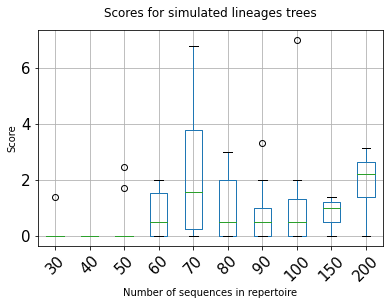

In [70]:
# box-plot for scores for different groups
boxplot = df_scores.boxplot(by = 'Groupe', column =['Score_ed'], grid = True, rot=45, fontsize=15)
boxplot.get_figure().gca().set_title("") 
boxplot.get_figure().suptitle('Scores for simulated lineages trees')
boxplot.get_figure().gca().set_ylabel("Score") 
boxplot.get_figure().gca().set_xlabel("Number of sequences in repertoire")
boxplot.plot()

plt.show()

In [71]:
# write in csv diffrence between ClonalTree and GStree trees
# DELETE LAST VERSION OF CSV FILE BEFORE EXECUTE
for key in dict_euclidean_m.keys():
    s = [key]
    for elem in dict_euclidean_m[key]:
        s.append(elem)
    with open("Analysis_simulated_dataset/2arbresdifferent.csv", "a") as p:
        pr = csv.writer(p, delimiter = ";", lineterminator = '\n')
        pr.writerow(s)


In [72]:
df2 = pd.read_csv('Analysis_simulated_dataset/2arbresdifferent.csv', delimiter=';', names=['Newick file', 'Number of branches', 'PD', 'avPD', 'H1', 'H2', 'H3', 'D1', 'D2', 'D3', 'SizeTree'])

In [73]:
# count how many times metrics were different
metrics = ['Number of branches', 'PD', 'avPD', 'H1', 'H2', 'H3', 'D1', 'D2', 'D3', 'SizeTree']
for metric in metrics:
    #print (df2[metric].value_counts())
    print ('Different ', metric, ' ', (df2[metric] != 0).sum(axis=0), '\n')

Different  Number of branches   1 

Different  PD   31 

Different  avPD   31 

Different  H1   13 

Different  H2   6 

Different  H3   3 

Different  D1   1 

Different  D2   6 

Different  D3   9 

Different  SizeTree   19 



In [74]:
# Difference for metrics
df3 = df2
df3 = df3.replace(0, np.NaN)
df3.describe()

,Number of branches,PD,avPD,H1,H2,H3,D1,D2,D3,SizeTree
count,1.00,31.00,31.00,13.00,6.00,3.00,1.00,6.00,9.00,19.00
mean,4.00,2.00,0.05,1.08,1.00,1.00,1.00,1.00,1.11,1.05
std,NaN,1.44,0.04,0.28,0.00,0.00,NaN,0.00,0.33,0.23
min,4.00,1.00,0.01,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,4.00,1.00,0.03,1.00,1.00,1.00,1.00,1.00,1.00,1.00
50%,4.00,1.00,0.04,1.00,1.00,1.00,1.00,1.00,1.00,1.00
75%,4.00,2.50,0.05,1.00,1.00,1.00,1.00,1.00,1.00,1.00
max,4.00,7.00,0.18,2.00,1.00,1.00,1.00,1.00,2.00,2.00


# Analysis of categorised dataset

In [75]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [76]:
df_ss = pd.read_csv('Analysis_categorised_dataset/simplifie_sequances.csv', delimiter=',', names=['Categorie', 'Number of branches', 'PD', 'avPD', 'H1', 'H2', 'H3', 'D1', 'D2', 'D3', 'SizeTree'])

In [77]:
df_ss

,Categorie,Number of branches,PD,avPD,H1,H2,H3,D1,D2,D3,SizeTree
0,1,16,39,2.44,2,1,1,1,2,2,4
1,1,17,31,1.82,2,1,0,2,3,3,5
2,1,17,53,3.12,2,1,0,3,4,4,6
3,1,16,63,3.94,2,1,0,3,4,4,6
4,1,17,46,2.71,4,1,0,2,5,3,7
5,2,18,38,2.11,1,2,0,3,2,4,5
6,2,17,33,1.94,1,1,0,2,1,3,4
7,3,22,34,1.55,1,0,3,3,1,3,7
8,3,19,74,3.89,1,5,0,3,2,6,8
9,3,17,49,2.88,1,4,2,5,2,4,7


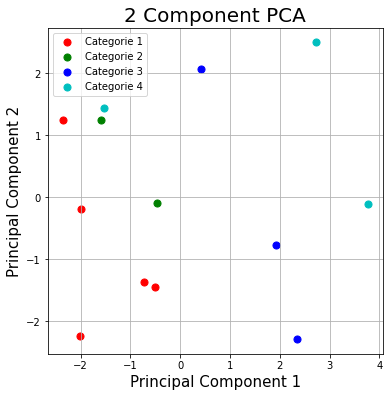

In [78]:
features = ['Number of branches','PD','avPD', 'H1', 'H2', 'H3', 'D1', 'D2','D3', 'SizeTree' ]
x = df_ss.loc[:, features].values
y = df_ss.loc[:,['Categorie']].values
x = StandardScaler().fit_transform(x)
#pd.DataFrame(data = x, columns = features)

n_components=2
pca = PCA(n_components)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])
#principalDf

#df[['Categorie']]

finalDf = pd.concat([principalDf, df_ss[['Categorie']]], axis = 1)
#finalDf

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

categories_labels = ['Categorie 1', 'Categorie 2', 'Categorie 3', 'Categorie 4']
categories = [1, 2, 3, 4]
colors = ['r', 'g', 'b', 'c']
for categorie, color in zip(categories,colors):
    indicesToKeep = finalDf['Categorie'] == categorie
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(categories_labels)
ax.grid()

In [79]:
#sum of explained variance ratio for 2 principal components 
pca.explained_variance_ratio_.cumsum()

array([0.38773391, 0.62287307])

In [80]:
#KNN results for Categorised dataset
C=np.zeros([len(categories),n_components])

#Initialization
#for i in categories:
#    A=finalDf[finalDf['Categorie']==i]
#    C[i-1][0]=np.average(A['PC1'])
#    C[i-1][1]=np.average(A['PC2'])

C_ant=C.copy()

arrete=0.01
alpha=-0.05
dif=10

while dif>arrete:
    #print(C_ant)
    for j in finalDf.index:
        dist=[]
        for i in range (len(categories)):
            #print(i,j)
            distance=( (C[i][0]-finalDf.loc[j]['PC1'])**2 + (C[i][1]-finalDf.loc[j]['PC2'])**2)**(1/2)
            dist.append(distance)
        p_min=np.argmin(dist)
        #print(p_min)
        
        C[p_min][0]=C[p_min][0]+alpha*(C[p_min][0]-finalDf.loc[j]['PC1'])
        C[p_min][1]=C[p_min][1]+alpha*(C[p_min][1]-finalDf.loc[j]['PC2'])
        #print(C)
    dif=np.max(abs(C_ant-C))#((C_ant[p_min][0]-C[p_min][0])**2 + (C_ant[p_min][1]-C[p_min][1])**2)**(1/2)
    #print(dif)
    C_ant=C.copy()
    
# Re-classification
finalDf['New_cat']=np.zeros([len(finalDf.index)])
for j in finalDf.index:
        dist=[]
        for i in range (len(categories)):
            #print(i,j)
            distance=( (C[i][0]-finalDf.loc[j]['PC1'])**2 + (C[i][1]-finalDf.loc[j]['PC2'])**2)**(1/2)
            dist.append(distance)
        #print(dist)
        p_min=np.argmin(dist)
        #print(p_min)
        finalDf.at[j,'New_cat']=int(p_min+1)

In [81]:
finalDf

,PC1,PC2,Categorie,New_cat
0,-2.35,1.25,1,1.00
1,-1.99,-0.19,1,1.00
2,-0.72,-1.36,1,4.00
3,-0.52,-1.45,1,4.00
4,-2.01,-2.24,1,4.00
5,-0.46,-0.10,2,4.00
6,-1.60,1.24,2,1.00
7,0.43,2.08,3,2.00
8,2.35,-2.28,3,3.00
9,1.92,-0.77,3,3.00


# Analysis of uncategorised dataset

In [82]:
# calculate metrics for VHC
dict_VHC = {}
for i in range (1, 10):
    file_fasta = 'VHC/VHC_dataset0' + str(i) + '_1_200_sequences.aln.fa'
    file_newick = 'VHC/VHC_dataset0' + str(i)+'_1_200_sequences.aln.fa.nk'
    dict_VHC[file_fasta[4:33]] = list(allMetrics(file_fasta, file_newick))
        
for i in range (10, 41):
    file_fasta = 'VHC/VHC_dataset' + str(i) + '_1_200_sequences.aln.fa'
    file_newick = 'VHC/VHC_dataset' + str(i)+'_1_200_sequences.aln.fa.nk'
    dict_VHC[file_fasta[4:33]] = list(allMetrics(file_fasta, file_newick))
    #print (i, allMetrics(file_fasta, file_newick))

In [83]:
# calculate metrics for MUT
MUT_fasta = []
with open ('Analysis_uncategorised_dataset/MUTnames.txt', 'r') as file:
    for line in file:
        MUT_fasta.append(line.replace('\n', ''))

dict_MUT = {}
for seq in MUT_fasta:
    file_fasta = 'MUT/' + seq
    file_newick = 'MUT/' + seq + '.nk'
    dict_MUT[file_fasta[4:-7]] = list(allMetrics(file_fasta, file_newick))

In [84]:
# calculate metrics for LLC
dict_LLC = {}
for i in range (1, 10):
    file_fasta = 'LLC/LLC_dataset0' + str(i) + '_1_200_sequences.aln.fa'
    file_newick = 'LLC/LLC_dataset0' + str(i)+'_1_200_sequences.aln.fa.nk'
    dict_LLC[file_fasta[4:33]] = list(allMetrics(file_fasta, file_newick))
        
for i in range (10, 57):
    file_fasta = 'LLC/LLC_dataset' + str(i) + '_1_200_sequences.aln.fa'
    file_newick = 'LLC/LLC_dataset' + str(i)+'_1_200_sequences.aln.fa.nk'
    dict_LLC[file_fasta[4:33]] = list(allMetrics(file_fasta, file_newick))

In [85]:
# create csv with metrics
def write_metrics_in_csv(our_dict, filename):    
    for key in our_dict.keys():
        if filename == 'LLC' or filename == 'MUT':
            groupe = 'LLC + MUT'
        else:
            groupe = 'VHC'
        s = [key, groupe]
        for elem in our_dict[key]:
            s.append(elem)
        with open('Analysis_uncategorised_dataset/' + groupe + '.csv', "a") as p:
            pr = csv.writer(p, delimiter = ";", lineterminator = '\n')
            pr.writerow(s)

In [86]:
# DELETE LAST VERSION OF CSV FILES BEFORE EXECUTE
write_metrics_in_csv(dict_LLC, 'LLC')
write_metrics_in_csv(dict_MUT, 'MUT')
write_metrics_in_csv(dict_VHC, 'VHC')

In [87]:
# datasets LLC+MUT and VHC
df_LLC_MUT = pd.read_csv('Analysis_uncategorised_dataset/LLC + MUT.csv', delimiter=';', names=['Newick file', 'Dataset', 'Number of branches', 'PD', 'avPD', 'H1', 'H2', 'H3', 'D1', 'D2', 'D3', 'SizeTree'])
df_VHC = pd.read_csv('Analysis_uncategorised_dataset/VHC.csv', delimiter=';', names=['Newick file', 'Dataset', 'Number of branches', 'PD', 'avPD', 'H1', 'H2', 'H3', 'D1', 'D2', 'D3', 'SizeTree'])

In [88]:
df_LLC_MUT.head()

,Newick file,Dataset,Number of branches,PD,avPD,H1,H2,H3,D1,D2,D3,SizeTree
0,LLC_dataset01_1_200_sequences,LLC + MUT,33,1153,34.94,2,0,0.00,3,4,5.00,6
1,LLC_dataset02_1_200_sequences,LLC + MUT,40,1429,35.73,2,0,4.00,4,6,2.00,7
2,LLC_dataset03_1_200_sequences,LLC + MUT,18,647,35.94,1,0,0.00,2,3,3.00,4
3,LLC_dataset04_1_200_sequences,LLC + MUT,68,2342,34.44,2,3,0.00,2,1,4.00,5
4,LLC_dataset05_1_200_sequences,LLC + MUT,35,1256,35.89,2,0,0.00,3,5,5.00,6


In [89]:
df_VHC.head()

,Newick file,Dataset,Number of branches,PD,avPD,H1,H2,H3,D1,D2,D3,SizeTree
0,VHC_dataset01_1_200_sequences,VHC,6,169,28.17,2,0,0.00,1,3,3.00,4
1,VHC_dataset02_1_200_sequences,VHC,95,3486,36.69,4,2,0.00,2,4,4.00,7
2,VHC_dataset03_1_200_sequences,VHC,10,412,41.20,2,3,0.00,2,1,2.00,5
3,VHC_dataset04_1_200_sequences,VHC,1,46,46.00,0,1,NaN,1,0,NaN,2
4,VHC_dataset05_1_200_sequences,VHC,82,2859,34.87,2,0,0.00,3,5,5.00,6


In [90]:
# percentage of H1, H2, H3 == 0
def h_count_zero(metric):
    print ('LLC + MUT ', metric, ' : ', round ((df_LLC_MUT[metric] == 0).sum(axis=0) / len(df_LLC_MUT), 1) * 100, '%\n')
    print ('VHC       ', metric, ' : ', (df_VHC[metric] == 0).sum(axis=0) / len(df_VHC) * 100, '%\n')

# percentage of D == i   
def d_count(metric, i):
    print ('LLC + MUT ', metric, ' = ', i, ' : ', round ((df_LLC_MUT[metric] == i).sum(axis=0) / len(df_LLC_MUT), 1) * 100, '%\n')
    print ('VHC       ', metric, ' = ', i, ' : ', round ((df_VHC[metric] == i).sum(axis=0) / len(df_VHC), 1) * 100, '%\n')
    
metricsH = ['H1', 'H2', 'H3']
metricsD = [ 'D1', 'D2', 'D3']

for m in metricsH:
    h_count_zero(m)

for m in metricsD:
    for i in range(1, 6):
        d_count(m, i)

LLC + MUT  H1  :  0.0 %

VHC        H1  :  5.0 %

LLC + MUT  H2  :  50.0 %

VHC        H2  :  70.0 %

LLC + MUT  H3  :  80.0 %

VHC        H3  :  90.0 %

LLC + MUT  D1  =  1  :  20.0 %

VHC        D1  =  1  :  20.0 %

LLC + MUT  D1  =  2  :  40.0 %

VHC        D1  =  2  :  20.0 %

LLC + MUT  D1  =  3  :  30.0 %

VHC        D1  =  3  :  50.0 %

LLC + MUT  D1  =  4  :  10.0 %

VHC        D1  =  4  :  0.0 %

LLC + MUT  D1  =  5  :  0.0 %

VHC        D1  =  5  :  0.0 %

LLC + MUT  D2  =  1  :  10.0 %

VHC        D2  =  1  :  10.0 %

LLC + MUT  D2  =  2  :  20.0 %

VHC        D2  =  2  :  10.0 %

LLC + MUT  D2  =  3  :  30.0 %

VHC        D2  =  3  :  20.0 %

LLC + MUT  D2  =  4  :  20.0 %

VHC        D2  =  4  :  20.0 %

LLC + MUT  D2  =  5  :  20.0 %

VHC        D2  =  5  :  30.0 %

LLC + MUT  D3  =  1  :  10.0 %

VHC        D3  =  1  :  0.0 %

LLC + MUT  D3  =  2  :  10.0 %

VHC        D3  =  2  :  20.0 %

LLC + MUT  D3  =  3  :  20.0 %

VHC        D3  =  3  :  10.0 %

LLC + MUT  D3  =  

In [91]:
# about VHC dataset
df_VHC.describe()

,Number of branches,PD,avPD,H1,H2,H3,D1,D2,D3,SizeTree
count,40.00,40.00,40.00,40.00,40.00,38.00,40.00,40.00,38.00,40.00
mean,50.55,1676.20,33.96,2.25,0.50,0.21,2.25,3.48,3.79,5.50
std,33.35,1178.13,6.64,1.10,0.88,0.93,0.84,1.54,1.28,1.62
min,1.00,46.00,8.43,0.00,0.00,0.00,1.00,0.00,1.00,2.00
25%,19.25,423.25,33.32,2.00,0.00,0.00,1.75,2.75,3.00,4.75
50%,55.00,1803.50,34.23,2.00,0.00,0.00,2.50,4.00,4.00,6.00
75%,72.25,2429.75,36.66,3.00,1.00,0.00,3.00,5.00,5.00,6.00
max,128.00,4504.00,46.00,6.00,3.00,5.00,3.00,6.00,5.00,10.00


In [92]:
# about LLC+MUT dataset
df_LLC_MUT.describe()

,Number of branches,PD,avPD,H1,H2,H3,D1,D2,D3,SizeTree
count,184.00,184.00,184.00,184.00,184.00,183.00,184.00,184.00,183.00,184.00
mean,57.02,1860.98,33.29,2.46,1.34,0.53,2.47,3.33,3.78,6.11
std,27.89,979.96,7.16,1.24,1.76,1.14,1.31,1.65,1.55,1.80
min,1.00,51.00,2.54,0.00,0.00,0.00,1.00,0.00,1.00,2.00
25%,37.00,1127.00,32.68,2.00,0.00,0.00,2.00,2.00,3.00,5.00
50%,55.50,1803.50,34.65,2.00,1.00,0.00,2.00,3.00,4.00,6.00
75%,73.00,2379.00,36.98,3.00,2.00,0.00,3.00,4.00,5.00,7.00
max,129.00,4645.00,51.00,7.00,8.00,6.00,9.00,9.00,9.00,12.00


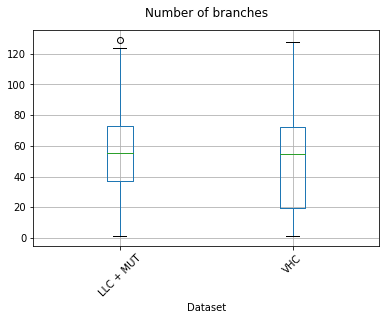

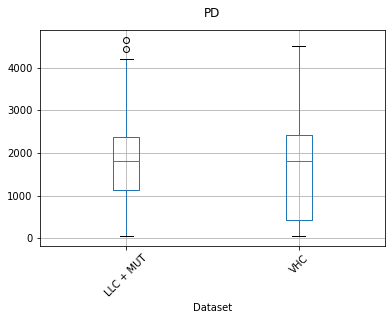

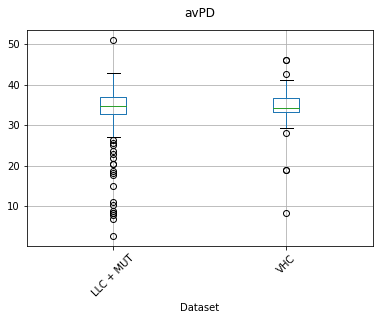

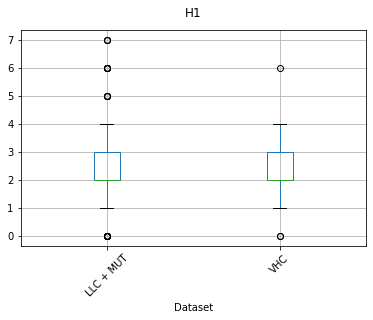

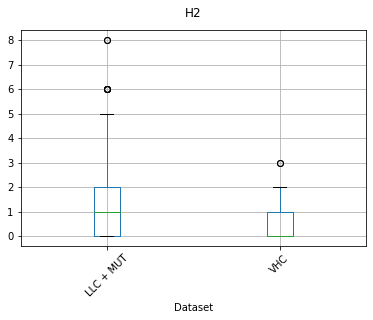

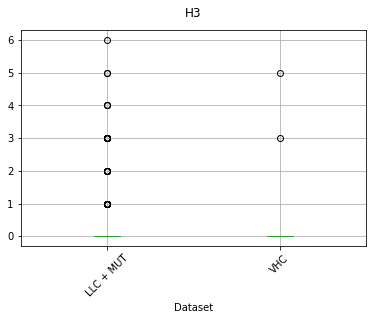

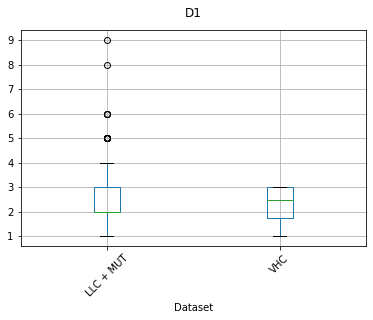

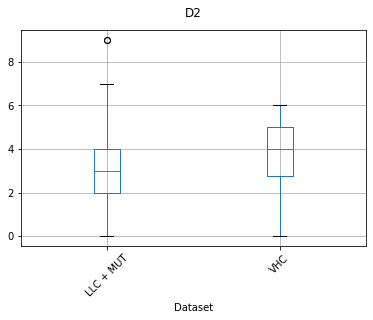

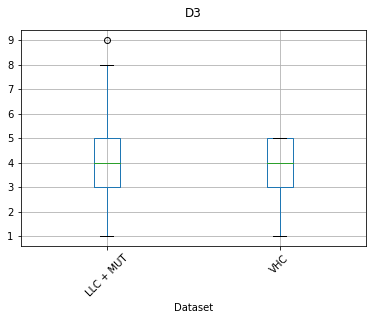

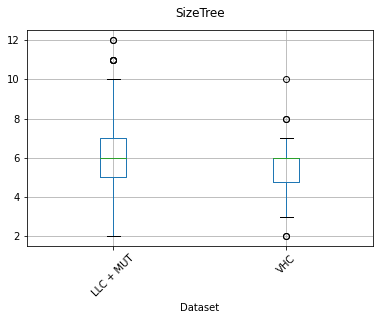

In [93]:
df_all = df_LLC_MUT.append(df_VHC, ignore_index=True)
# boxplots for metrics
def made_boxplot(metric):
    boxplot = df_all.boxplot(by = 'Dataset', column =[metric], grid = True, rot=45, fontsize=10)

    boxplot.get_figure().gca().set_title("") 
    boxplot.get_figure().suptitle(metric)
    #boxplot.get_figure().gca().set_ylabel("H1") 
    #boxplot.get_figure().gca().set_xlabel("Number of sequences in repertoire")
    boxplot.plot()

    plt.show()
    
metrics = ['Number of branches', 'PD', 'avPD', 'H1', 'H2', 'H3', 'D1', 'D2', 'D3', 'SizeTree']
for metric in metrics:
    made_boxplot(metric)